In [1]:
# %% Global Variables
datasetPath = "./TM-3-2020/data/"
sourceCodePath = './src'

# taken from https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

In [2]:
# %% libraries
import numpy as np
import pandas as pd
import os
import sys
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import torch

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# %% Loads Dataset
sys.path.append(os.path.join(os.getcwd(), sourceCodePath))
import chat as ch

dataset = ch.dataset.Dataset(datasetPath)
# %%
df = dataset.get_dataframe()
df.head()

,conversation_id,scenario,instructions,conversation,intent,success
0,dlg-bca5ce0a-056f-446e-be94-3ba77b32a84f,auto template 1 with theater name error,"scenario: in the conversation below, a custome...",hi....am buying a ticket tonight so we go and ...,buy,1
1,dlg-bd494e2c-36f6-4529-8e4d-d5c4d64388ae,auto template 1 with theater name error,"scenario: in the conversation below, a custome...",I am looking for tickets tonight at the AMC Mo...,buy,1
2,dlg-c9064676-75fe-4d0a-83c2-497e1f2115a6,auto template 1 with theater name error,"scenario: in the conversation below, a custome...",I need to get some tickets for a movie tonight...,buy,1
3,dlg-f7500bcf-472c-48c3-adfd-e4ec9f63bcf1,auto template 1 with theater name error,"scenario: in the conversation below, a custome...",I need help finding showtimes for tonight at m...,buy,1
4,dlg-df1f0d45-27f2-4fb0-8aaa-b6b5f5a843bb,auto template 1 with theater name error,"scenario: in the conversation below, a custome...","Hello, I am interested in buying tickets tonig...",buy,1


In [4]:
from transformers import AutoTokenizer, BertTokenizer, BertModel
model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name)

In [5]:
text_array = dataset.get_text_utterances()

In [18]:
''' esto lanza error todavia porque hay que segmentar el corpus mucho mas, esta muy grande y BERT no lo procesa MAX: 512
corpus = ''
for row in text_array:
    corpus += row

corpus = re.sub(r'[,!?;-]', '.', corpus)
corpus = '[CLS]' + corpus + '[SEP]'
'''
corpus = "[CLS]hi, i'm alexander [SEP]hi, i'm florida theatre assistant. [SEP]ok, i want some tickets [SEP]which movie [SEP]bad boys for life [SEP]ok, today or tommorrow [SEP]today. [SEP]how many tickets you want? [SEP]five tickets. [SEP]which show? [SEP]evening show. [SEP]ok, one ticket $ 5.50 [SEP]ok, i will send $ 27.50 [SEP]ok, if you sent money. i will buy the tickets and send the ticket copy to you. [SEP]ok, please check. i sended the money. [SEP]yes, i receive the money. [SEP]ok, please send the ticket copies. [SEP]yes, please check you will receive the ticket copy. [SEP]yes. thank you. [SEP]ok[SEP]"

In [19]:
print('corpus size:',len(corpus))
corpus[:4000]

corpus size: 603


"[CLS]hi, i'm alexander [SEP]hi, i'm florida theatre assistant. [SEP]ok, i want some tickets [SEP]which movie [SEP]bad boys for life [SEP]ok, today or tommorrow [SEP]today. [SEP]how many tickets you want? [SEP]five tickets. [SEP]which show? [SEP]evening show. [SEP]ok, one ticket $ 5.50 [SEP]ok, i will send $ 27.50 [SEP]ok, if you sent money. i will buy the tickets and send the ticket copy to you. [SEP]ok, please check. i sended the money. [SEP]yes, i receive the money. [SEP]ok, please send the ticket copies. [SEP]yes, please check you will receive the ticket copy. [SEP]yes. thank you. [SEP]ok[SEP]"

In [20]:
# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(corpus)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

In [21]:
# Display the words with their indeces.

print('tokenized_text:', len(tokenized_text))
print('indexed_tokens:', len(indexed_tokens))
print()
i=0
for tup in zip(tokenized_text, indexed_tokens):
    if i > 20:
        break

    print('{:<12} {:>6,}'.format(tup[0], tup[1]))
    
    i += 1

tokenized_text: 152
indexed_tokens: 152

[CLS]           101
hi            7,632
,             1,010
i             1,045
'             1,005
m             1,049
alexander     3,656
[SEP]           102
hi            7,632
,             1,010
i             1,045
'             1,005
m             1,049
florida       3,516
theatre       3,004
assistant     3,353
.             1,012
[SEP]           102
ok            7,929
,             1,010
i             1,045


In [22]:
# Convert inputs to PyTorch tensors
segments_ids = [1] * len(tokenized_text)
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [23]:
print('segments_ids',len(segments_ids))
print('tokens_tensor',tokens_tensor.size())
print('segments_tensors',segments_tensors.size())

segments_ids 152
tokens_tensor torch.Size([1, 152])
segments_tensors torch.Size([1, 152])


In [24]:
list(tokenizer.vocab.keys())[4000:4020]

['tears',
 'senate',
 '00',
 'card',
 'asian',
 'agent',
 '1947',
 'software',
 '44',
 'draw',
 'warm',
 'supposed',
 'com',
 'pro',
 '##il',
 'transferred',
 'leaned',
 '##at',
 'candidate',
 'escape']

In [25]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained(model_name, output_hidden_states = True) # Whether the model returns all hidden-states.

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [26]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 

i = 0
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        
    hidden_states = outputs[2]

In [27]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 152
Number of hidden units: 768


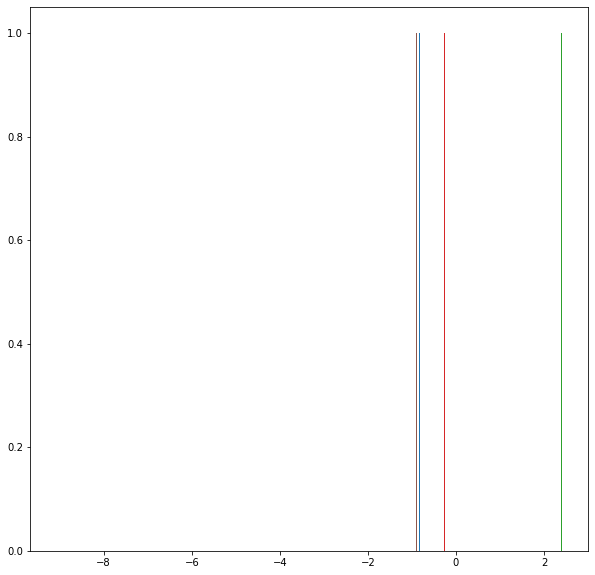

In [28]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [29]:
# `hidden_states` is a Python list.
print('Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 152, 768])


In [30]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 152, 768])

In [31]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 152, 768])

In [32]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([152, 13, 768])

In [40]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_sum.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 152 x 3072


In [41]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [42]:
sentence_embedding.size()

torch.Size([768])

In [43]:
for i, token_str in enumerate(tokenized_text):
    if i > 50:
        break
    i += 1

    print (i, token_str)

1 [CLS]
2 hi
3 ,
4 i
5 '
6 m
7 alexander
8 [SEP]
9 hi
10 ,
11 i
12 '
13 m
14 florida
15 theatre
16 assistant
17 .
18 [SEP]
19 ok
20 ,
21 i
22 want
23 some
24 tickets
25 [SEP]
26 which
27 movie
28 [SEP]
29 bad
30 boys
31 for
32 life
33 [SEP]
34 ok
35 ,
36 today
37 or
38 tom
39 ##mo
40 ##rrow
41 [SEP]
42 today
43 .
44 [SEP]
45 how
46 many
47 tickets
48 you
49 want
50 ?
51 [SEP]


In [44]:
example_word_index_1 = 23
example_word_index_2 = 46

print('word:',tokenized_text[example_word_index_1])

print('vector values for:', tokenized_text[example_word_index_1])
print('vector values for:', tokenized_text[example_word_index_2])
print('')
print(tokenized_text[example_word_index_1], str(token_vecs_sum[example_word_index_1][:5]))
print(tokenized_text[example_word_index_2], str(token_vecs_sum[example_word_index_2][:5]))


word: tickets
vector values for: tickets
vector values for: tickets

tickets tensor([ 0.3811, -0.1762,  0.2199,  0.8139,  0.0592])
tickets tensor([ 0.9321, -0.0481,  0.4145,  0.6878,  0.1209])


In [45]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_word = 1 - cosine(token_vecs_sum[example_word_index_1], token_vecs_sum[example_word_index_2])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_word = 1 - cosine(token_vecs_sum[example_word_index_1], token_vecs_sum[example_word_index_2])

print('Vector similarity for  *similar*  meanings:  %.2f' % diff_word)
print('Vector similarity for *different* meanings:  %.2f' % same_word)

Vector similarity for  *similar*  meanings:  0.91
Vector similarity for *different* meanings:  0.91
